### Gradient descent

In this notebook I am going to present the operation of the steepest descent method with variable step size

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def target_function(x1, x2):
    return (1.5 - x1 + x1*x2)**2 + \
            (2.25 - x1 + x1*(x2**2))**2 + \
            (2.625 - x1 + x1*(x2**3))**2

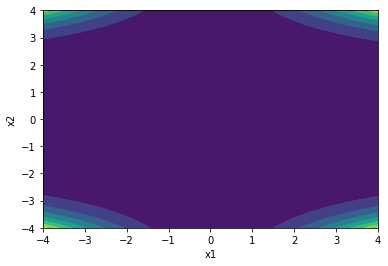

In [3]:
x1 = np.linspace(-4, 4, 200)
x2 = np.linspace(-4, 4, 200)
x1v, x2v = np.meshgrid(x1, x2)
z = target_function(x1v, x2v)
plt.contourf(x1v,x2v,z)
plt.xlabel('x1')
plt.ylabel('x2')

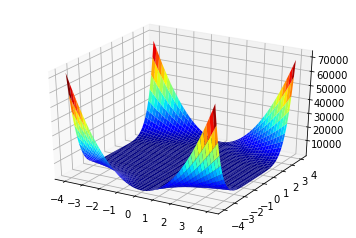

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 

plt.figure()
ax = plt.subplot(111, projection='3d')
ax.plot_surface(x1v,x2v,z, cmap=cm.jet)

I start with the visualization. From the shape of the function we can immediately conclude that:
    1. There can be plausibly a lot of local minima
    2. There will be a problem with overshooting by the gradient method

Because of the simple fact that symbolic calculations are usually not effective, I have decided to implement a directional derivative. The function requires the step parameter, that determines how infinitesimal the derivative can actually be

In [5]:
def numerical_derivative(function, x1, x2, step):
    d1 = (function(x1 + step, x2) - function(x1, x2))/step
    d2 = (function(x1, x2 + step) - function(x1, x2))/step
    return d1, d2

To implement a gradient descent, I am going to need an algorithm that will calculate the optimal value of the step at each iteration. 
$$ x_{i+1} = x_{i} - \alpha d_{i} $$
I can put constraints for the value of \alpha since I know the bounds on x (the suspected minimum interval), thus I can calculate upper and lower limits for this parameter. Now I only need an optimizing function that will minimize the function:
    $$\min_{\alpha} \ function( x_{i} - \alpha d_{i})$$
For that purpose, I have decided to use Fibonacci method

In [6]:
def fib_formula(n):
    return (1/np.sqrt(5))*(((1+np.sqrt(5))/2)**n-((1-np.sqrt(5))/2)**n)

def find_closest_fibonacci(x):
    n = 0
    while fib_formula(n) <= x:
        n += 1
    return fib_formula(n), n

In [7]:
def gradient_descent(function, x10, x20, error, N):
    x1 = x10
    x2 = x20
    x1_list = []
    x2_list = []
    d_list =[]
    i = 0
    step = 1e-6 
    
    d1, d2 = numerical_derivative(function, x1, x2, step)
    value = np.sqrt(d1**2 + d2**2)    

    x1_list.append(x1)
    x2_list.append(x2)
   
    d_list.append((d1, d2))
    
    verbose = 0
    upper_limit = 4
    lower_limit = -4
    
    while np.abs(function(x1, x2)) > error and np.sqrt(d1**2 + d2**2) > error:
        d1, d2 = numerical_derivative(function, x1, x2, step)
        if verbose:
            print("d1: {}, d2: {}".format(d1, d2))
            print("x1: {}, x2: {}".format(x1, x2))
            print("Value of function: {}".format(function(x1, x2)))
        
        #constraints for x1 and x2, finding alpha
        if d1 != 0.0:
            l11 = (upper_limit - x1)/(-1.0*d1)
            l12 = (lower_limit - x1)/(-1.0*d1)

        if d2 != 0.0:
            l21 = (upper_limit - x2)/(-1.0*d2)
            l22 = (lower_limit - x2)/(-1.0*d2)
            
        if d1 !=0.0 and d2!=0.0:    
            if l11 < l12:
                a1limit = [l11, l12]
            else:
                a1limit = [l12, l11]

            if l21 < l22:
                a2limit = [l21, l22]
            else:
                a2limit = [l22, l21]   

            if a1limit[0] < a2limit[0]:
                lower_bound = a1limit[0]
            else:
                lower_bound = a2limit[0]

            if a1limit[1] < a2limit[1]:
                upper_bound = a1limit[1]
            else:
                upper_bound = a2limit[1]
                
        elif d1 == 0.0:
            lower_bound = np.min([l21, l22])
            upper_bound = np.max([l21, l22])
        elif d2 == 0.0:
            lower_bound = np.min([l11, l12])
            upper_bound = np.max([l11, l12])

        a = lower_bound
        b = upper_bound
        
        #Fibonacci optimization
        beta = (b-a)/float(error)
        phi_k, k = find_closest_fibonacci(beta) 
        phi_k2 = fib_formula(k-1)
        c = b - (phi_k2/phi_k)*(b - a)
        d = a + b - c
        for j in range(k-4):
            if function(x1-c*d1, x2-c*d2) < function(x1-d*d1, x2-d*d2):
                b = d
            else:
                a = c
            c = b - (fib_formula(k-2-j)/fib_formula(k-1-j))*(b - a)
            d = a + b - c     
                
        alpha = c
        x1 = x1 - alpha*d1
        x2 = x2 - alpha*d2
        
        x1_list.append(x1)
        x2_list.append(x2)
        d_list.append((d1, d2))
        
        value = np.sqrt(d1**2 + d2**2)  
        
        i += 1
        if i > N:
            break
    return x1, x2

The function still sometimes blows up despite putting on some constraints. This is happening due to the loss of precision i.e. because of the numerical limitation, sometimes gradient ($d_1$ or $d_2$ reaches a value so close to zero, the compiler actually believes it is virtually zero. Then dividing by this virtual zero results in wrong values. However, most of the time, it works really well

In [8]:
x1 = 8*np.random.random((200,1)) - 3.999
x2 = 8*np.random.random((200,1)) - 3.999
minima_x1 = []
minima_x2 = []
x1_start = []
x2_start = []
for x, y in zip(x1, x2):
    if len(minima_x1) == 100:
        break
    x1, x2 = gradient_descent(target_function, x, y, 1e-6, 500)    
    if x1 < 4.0 and x2 <4.0 and x1 >-4.0 and x2>-4.0:
        minima_x1.append(np.around(x1,decimals=3))
        minima_x2.append(np.around(x2,decimals=3))
        x1_start.append(np.around(x,decimals=3))
        x2_start.append(np.around(y,decimals=3))
    else:
        pass

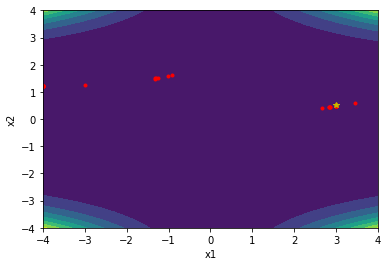

In [9]:
x1 = np.linspace(-4, 4, 200)
x2 = np.linspace(-4, 4, 200)
x1v, x2v = np.meshgrid(x1, x2)
z = target_function(x1v, x2v)

plt.contourf(x1v,x2v,z)
plt.xlabel('x1')
plt.ylabel('x2')
plt.plot(minima_x1, minima_x2, 'r.')
plt.plot(3, 0.5, 'y*')

From the attached picture we can clearly see some point that did not converge - this might be due to the insufficient number of steps provided in the method. However, the overwhelming majority did manage to converge to the true minimum which is in (3, 0.5) and marked as yellow star. 
Below we see the deviation form these coordinates. Clearly only some points are off.

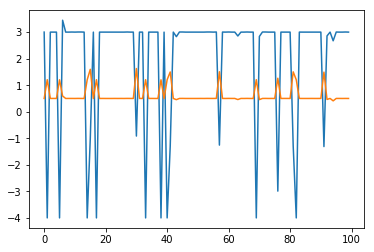

In [10]:
plt.figure()
plt.plot(minima_x1)
plt.plot(minima_x2)

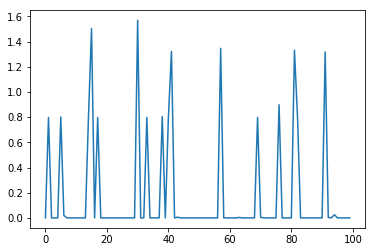

In [11]:
z= [target_function(x, y) for x, y in zip(minima_x1, minima_x2)]
plt.plot(z)

Conclusions:
    1. Variable step gradient method provides a quick convergest to minumum despite complexity of calculations
    2. Compared to other methods, gradients are easier to comprehend mathematically
    3. Despite constraints, there is some occasional blowup od minimum
    4. Gradient descent can be relatively resistant to local minima if step is adjusted accurately
    5. In case of Rosenbrock function, gradient needed much fewer steps than presented 500 to reach desired accuracy, which    is the case for most points

In [15]:
class ListTable(list):
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [16]:
table = ListTable()
table.append(['#','Starting point: x1', 'Starting point: x2', 'Minimum x1', 'Minimum x2'])
count = 1
for x1s, x2s, x1m, x2m in zip(x1_start, x2_start, minima_x1, minima_x2):    
    table.append([count, x1s[0], x2s[0], x1m[0], x2m[0]])
    count+= 1

In [17]:
table

#,Starting point: x1,Starting point: x2,Minimum x1,Minimum x2
1,-0.282,1.231,2.998,0.5
2,-3.196,2.456,-4.0,1.206
3,0.516,1.643,2.998,0.5
4,3.456,-3.419,2.998,0.5
5,-1.581,-3.281,2.998,0.5
6,-3.116,2.674,-4.0,1.203
7,-3.526,-1.372,3.445,0.591
8,-1.364,2.88,2.998,0.499
9,-0.329,-0.989,2.998,0.5
10,2.177,0.585,3.001,0.5
